**Table of contents**<a id='toc0_'></a>

- [Setting up data and imports](#toc1_1_1_1_1_)
  - [Optimization Setup](#toc1_1_1_2_)
  - [SpOPT](#toc1_1_1_3_)
  - [PyMOO Testing](#toc1_1_1_4_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


##### <a id='toc1_1_1_1_1_'></a>[Setting up data and imports](#toc0_)


In [3]:
import numpy as np
from importlib import reload

# Importing my modules
from src.main import (
    classes,
    geometry_operations,
    optimization_functions,
    plotting_2d,
    plotting_3d,
)

In [4]:
# %store -r line_gdf_reworked
%store -r line_gdf_75
%store -r harvesteable_trees_gdf
%store -r height_gdf
%store -r anchor_trees_gdf
%store -r target_trees_gdf
%store -r line_gdf_v1
%store -r slope_line

line_gdf = line_gdf_v1.copy()
# hack to extract this from the line_gdf
start_point_dict = dict(
    [(key, value.coords[0]) for key, value in enumerate(line_gdf["line_candidates"])]
)

#### <a id='toc1_1_1_2_'></a>[Optimization Setup](#toc0_)


In [23]:
bhd_series = harvesteable_trees_gdf["BHD"]
height_series = harvesteable_trees_gdf["h"].replace(",", ".", regex=True).astype(float)

# Prepare the gdfs
uphill_yarding = False
line_gdf["line_cost"] = optimization_functions.compute_line_costs(
    line_gdf, uphill_yarding, large_yarder=True
)
harvesteable_trees_gdf["cubic_volume"] = optimization_functions.compute_tree_volume(
    bhd_series, height_series
)

#### <a id='toc1_1_1_3_'></a>[SpOPT](#toc0_)


In [96]:
reload(optimization_functions)
reload(classes)
# Lists to store the results
optimization_result_list = []
lscp_model_list = []

for i in range(0, 3):
    print(f"Starting with objective {i}")
    # set up the model with firs the monetary objective (0), then sideways slope (1) and steep segments (2) as single objective
    lscp_optimization = classes.optimization_model(
        "Single Objective",
        line_gdf,
        harvesteable_trees_gdf,
        height_gdf,
        slope_line,
        objective_to_select=i,
    )
    lscp_optimization.add_generic_vars_and_constraints()
    lscp_optimization.add_single_objective()
    # and solve it
    lscp_optimization.solve()
    lscp_model_list.append(lscp_optimization)

Starting with objective 0
Starting with objective 1
Starting with objective 2


In [88]:
for count, optimization_object in enumerate(lscp_model_list):
    optimization_result_list.append(
        classes.optimization_result(
            optimization_object,
            line_gdf,
            0,
            False,
            optimization_object.name + str(count),
        )
    )

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to b

In [135]:
from src.main import global_vars

kdtree = global_vars.init(height_gdf)
fig = plotting_3d.plot_3d_model_results(model_list[1].model, line_gdf, height_gdf)
fig.show("notebook_connected")

Cable road created from line:  (-15.12792573, -26.16056076) to  (-29.880646898378075, -8.757599103801436)


AttributeError: 'Support' object has no attribute 'xy_location_numpy'

#### E-Constraint MOO


In [95]:
epsilon_model_list = []
for index in range(0, 2):
    e_optimization = classes.single_objective_optimization_model(
        "name", line_gdf, harvesteable_trees_gdf, height_gdf, slope_line, uphill_yarding
    )
    model = optimization_functions.optimize_cable_roads_epsilon_constraint(
        e_optimization, index
    )
    epsilon_model_list.append(model)
    optimization_result_list.append(
        classes.optimization_result(
            model, line_gdf, 0, False, "e-Constraint " + str(index)
        )
    )

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### <a id='toc1_1_1_4_'></a>[PyMOO Testing](#toc0_)


In [96]:
from src.main import moo_optimization_functions
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

reload(moo_optimization_functions)

cost_matrix = lscp_model_list[0].aij
nsga_problem = moo_optimization_functions.SupportLinesProblem(
    cost_matrix, lscp_model_list[0].facility_cost
)
termination = get_termination("n_gen", 20)

reload(optimization_functions)

client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    pop_size=50,
    sampling=moo_optimization_functions.CustomSampling(),  # initally zero matrix, nothing assigned
    mutation=moo_optimization_functions.MyMutation(),
    repair=moo_optimization_functions.MyRepair(),
)

# %prun minimize(problem,algorithm,termination,verbose=True,return_least_infeasible=True,seed=0)
res = minimize(
    nsga_problem,
    algorithm,
    termination,
    verbose=True,
    return_least_infeasible=True,
    seed=0,
)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  5.159484E+02 |  5.159484E+02 |             - |             -
     2 |       51 |      7 |  0.000000E+00 |  0.000000E+00 |             - |             -
     3 |      101 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0269916010 |         ideal
     4 |      151 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0087122263 |         ideal
     5 |      201 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0036806771 |         ideal
     6 |      251 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0136701377 |             f
     7 |      301 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0208776548 |             f
     8 |      351 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0033320483 |         ideal
     9 |      401 |     16 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      451 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0056388342 |             f

In [97]:
len_x = len(res.X)
samples = 4
for i in np.linspace(0, len_x - 1, samples).astype(int):
    optimization_result_list.append(
        classes.optimization_result(res, line_gdf, i, False, "NSGA2 " + str(i))
    )

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to b

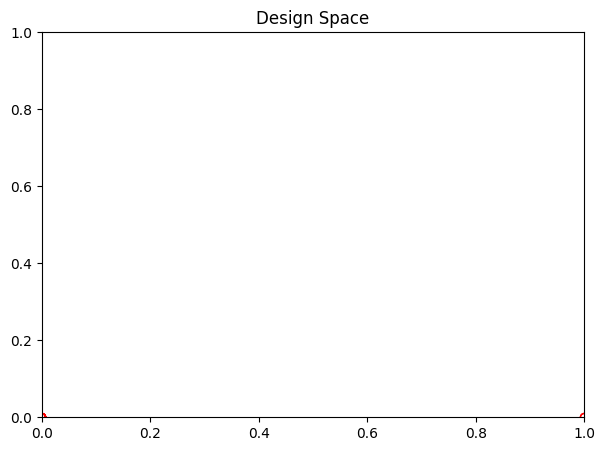

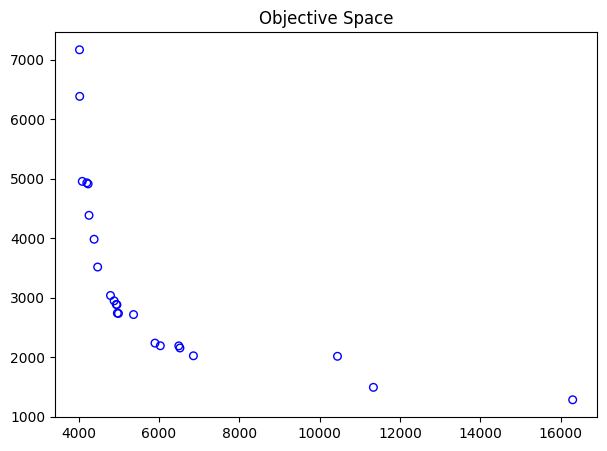

In [98]:
plotting_2d.plot_NSGA_results(X, F, nsga_problem)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})

# for x_sol in range(0,X.shape[0],4):
#     plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

def plot_explain(i):
    plotting_2d.plot_pymoo_results(X[int(i)], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=X.shape[0], step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=51.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>

In [53]:
a = sample_model.productivity_cost

#### Comparison of Optimization Results


In [89]:
tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
(
    distance_tree_line,
    distance_carriage_support,
) = geometry_operations.compute_distances_facilities_clients(
    harvesteable_trees_gdf, line_gdf
)
sample_model = lscp_model_list[0]
reload(classes)
reload(plotting_2d)
import pandas as pd

pd.options.plotting.backend = "hvplot"

results_df = plotting_2d.model_results_comparison(
    optimization_result_list,
    line_gdf,
    sample_model.aij,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
    sample_model.sideways_slope_deviations_per_cable_road,
    sample_model.steep_downhill_segments,
)
display(results_df)
results_df.plot()

Profit baseline is 51853.884670017214


,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,sideways_slope_deviations,steep_downhill_segments
0,5450.915246,3334.885922,44441.141853,63025.435582,2001.318079,11171.550912,model0,384.964595,326.744007
1,20988.993467,14506.436834,39476.012292,51853.884670,759.655202,0.000000,model1,114.831001,114.831001
2,19413.397043,12948.895542,40894.567152,53411.425962,575.692242,1557.541292,model2,134.391515,58.379281


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [52]:
for result in optimization_result_list:
    plotting_2d.plot_optimization_layout(result, line_gdf, harvesteable_trees_gdf)

### Creating the reference table for AUGMECON approach


In [55]:
columns_to_select = [
    "overall_profit",
    "sideways_slope_deviations",
    "steep_downhill_segments",
]
display(results_df[columns_to_select])

,overall_profit,sideways_slope_deviations,steep_downhill_segments
0,63025.435582,384.964595,326.744007
1,51853.884670,114.831001,114.831001
2,53411.425962,134.391515,58.379281


In [108]:
# first normalize sideways and downhill for relative negative impact
sideways_true_max = results_df["sideways_slope_deviations"].max()
downhill_true_max = results_df["steep_downhill_segments"].max()

results_df["sideways_slope_deviations_rni"] = (
    results_df["sideways_slope_deviations"] / sideways_true_max
)
results_df["steep_downhill_segments_rni"] = (
    results_df["steep_downhill_segments"] / downhill_true_max
)
columns_to_select = [
    "overall_profit",
    "sideways_slope_deviations_rni",
    "steep_downhill_segments_rni",
]
display(results_df[columns_to_select])

,overall_profit,sideways_slope_deviations_rni,steep_downhill_segments_rni
0,63025.435582,1.000000,1.00000
1,51853.884670,0.298290,0.35144
2,53411.425962,0.349101,0.17867


In [110]:
# determine the ranges of the objectives and divide them in 10 equal parts
# this is done to create a grid of points to evaluate the objective functions

# first determine the ranges of the objectives
max_overall_profit = results_df["overall_profit"].max()
min_overall_profit = results_df["overall_profit"].min()
max_sideways_slope_deviations_rni = (
    results_df["sideways_slope_deviations_rni"].max() * 100
)
min_sideways_slope_deviations_rni = (
    results_df["sideways_slope_deviations_rni"].min() * 100
)
max_steep_downhill_segments_rni = results_df["steep_downhill_segments_rni"].max() * 100
min_steep_downhill_segments_rni = results_df["steep_downhill_segments_rni"].min() * 100

# create a grid of points to evaluate the objective functions
profit_range = np.linspace(min_overall_profit, max_overall_profit, 10)
sideways_range, sideways_step = np.linspace(
    max_sideways_slope_deviations_rni,
    min_sideways_slope_deviations_rni,
    10,
    retstep=True,
)
downhill_range, downhill_step = np.linspace(
    max_steep_downhill_segments_rni, min_steep_downhill_segments_rni, 10, retstep=True
)

display("profit_range:", profit_range)
display("sideways_range:", sideways_range)
display("downhill_range:", downhill_range)

'profit_range:'

array([51853.88467002, 53095.16810472, 54336.45153943, 55577.73497413,
       56819.01840884, 58060.30184354, 59301.58527825, 60542.86871296,
       61784.15214766, 63025.43558237])

'sideways_range:'

array([100.        ,  92.20321969,  84.40643937,  76.60965906,
        68.81287874,  61.01609843,  53.21931811,  45.4225378 ,
        37.62575748,  29.82897717])

'downhill_range:'

array([100.        ,  90.87410871,  81.74821742,  72.62232613,
        63.49643484,  54.37054355,  45.24465226,  36.11876096,
        26.99286967,  17.86697838])

In [ ]:
from itertools import islice

reload(classes)
reload(optimization_functions)


def augmecon():
    initial_model = classes.optimization_model(
        "Single Objective",
        line_gdf,
        harvesteable_trees_gdf,
        height_gdf,
        slope_line,
        objective_to_select=0,
    )

    initial_model.add_generic_vars_and_constraints()
    # add the main monetary objective
    initial_model.add_single_objective()

    # set up the ranges at iteration objects so we can skip steps in the loop
    i_range = iter(sideways_range)
    j_range = iter(downhill_range)

    for i in i_range:
        print("i:", i)
        initial_model.add_epsilon_constraint(target_value=i, objective_to_select=1)

        (
            cost_objective,
            sideways_objective,
            steep_objective,
        ) = initial_model.get_objective_values(sideways_true_max, downhill_true_max)
        # determine the slack variable of the sideways constraint - this is the value of the objective function minus the expected value as per the sideways range
        i_slack = sideways_objective - i

        # loop through the inner objective
        for j in j_range:
            print("j:", j)
            initial_model.add_epsilon_constraint(target_value=j, objective_to_select=2)

            initial_model.solve()

            (
                cost_objective,
                sideways_objective,
                steep_objective,
            ) = initial_model.get_objective_values(sideways_true_max, downhill_true_max)

            # determine the slack variable of the downhill constraint - this is the value of the objective function minus the expected value as per the downhill range
            j_slack = steep_objective - j

            # the expected value as per the downhill range. If the slack variable is greater than what we would constrain for the next step, we skip those iterations
            j_bypass = np.floor(j_slack / downhill_step)
            if j_bypass < 0:
                # for iterator j, skip j_bypass steps
                next(islice(j_range, j_bypass, j_bypass), None)

            # add the epsilon objective for the remaining objectives
            initial_model.add_epsilon_objective(
                i_slack, j_slack, sideways_range, downhill_range
            )


augmecon()

i: 100.0
j: 100.0


In [24]:
import plotly.graph_objs as go
import plotly.offline as py

import pandas as pd
import numpy as np
from ipywidgets import interactive, HBox, VBox

lats, lons, names = [], [], []
for id, row in line_gdf.iterrows():
    p1, p2 = row.geometry.xy
    lats = np.append(lats, p1[0])
    lats = np.append(lats, p2[0])
    lons = np.append(lons, p1[1])
    lons = np.append(lons, p2[1])
    names = np.append(names, str(id) + "_0")
    names = np.append(names, str(id) + "_1")

# get the 2D figure of all CRs
import plotly.express as px

f = go.FigureWidget([go.Scatter(y=lons, x=lats, mode="lines")])

f.update_layout(width=800, height=800)
scatter = f.data[0]
f.show()
# f = go.FigureWidget([go.Scatter(y = df['City mpg'], x = df['City mpg'], mode = 'markers')])
# scatter = f.data[0]
# N = len(df)
# scatter.x = scatter.x + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
# scatter.y = scatter.y + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
# scatter.marker.opacity = 0.5

# def update_axes(xaxis, yaxis):
#     scatter = f.data[0]
#     scatter.x = df[xaxis]
#     scatter.y = df[yaxis]
#     with f.batch_update():
#         f.layout.xaxis.title = xaxis
#         f.layout.yaxis.title = yaxis
#         scatter.x = scatter.x + np.random.rand(N)/10 *(df[xaxis].max() - df[xaxis].min())
#         scatter.y = scatter.y + np.random.rand(N)/10 *(df[yaxis].max() - df[yaxis].min())

# axis_dropdowns = interactive(update_axes, yaxis = df.select_dtypes('int64').columns, xaxis = df.select_dtypes('int64').columns)

# # Create a table FigureWidget that updates on selection from points in the scatter plot of f
# t = go.FigureWidget([go.Table(
#     header=dict(values=['ID','Classification','Driveline','Hybrid'],
#                 fill = dict(color='#C2D4FF'),
#                 align = ['left'] * 5),
#     cells=dict(values=[df[col] for col in ['ID','Classification','Driveline','Hybrid']],
#                fill = dict(color='#F5F8FF'),
#                align = ['left'] * 5))])

# def selection_fn(trace,points,selector):
#     t.data[0].cells.values = [df.loc[points.point_inds][col] for col in ['ID','Classification','Driveline','Hybrid']]

# scatter.on_selection(selection_fn)

# # Put everything together
# VBox((HBox(axis_dropdowns.children),f,t))
print("done")

done
